In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

X = np.load('../pose/actions.npy')
y = np.load('../pose/labels.npy')

labels = np.unique(y)

le = LabelEncoder()
le.fit(y)
le_y = np.array(le.transform(y))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y = ohe.transform(le_y).toarray()

In [2]:
X.shape

(16, 30, 34)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [4]:
window_size = 30
num_keypoints = 34

In [5]:
# model_lstm = Sequential()
# model_lstm.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'), 
#                                 input_shape=(10, 250, 250, 1)))
# model_lstm.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
# model_lstm.add(TimeDistributed(MaxPooling2D(2,2)))
# model_lstm.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
# model_lstm.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
# model_lstm.add(TimeDistributed(MaxPooling2D(2,2)))
# model_lstm.add(TimeDistributed(BatchNormalization()))


# model_lstm.add(TimeDistributed(Flatten()))
# model_lstm.add(Dropout(0.2))

# model_lstm.add(LSTM(32, return_sequences=False, dropout=0.2)) # used 32 units

# model_lstm.add(Dense(64,activation='relu'))
# model_lstm.add(Dense(32,activation='relu'))
# model_lstm.add(Dropout(0.2))
# model_lstm.add(Dense(1, activation='sigmoid'))
# model_lstm.summary()

In [6]:
X_test.shape

(5, 30, 34)

In [7]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, Dense, ConvLSTM2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential(name="lstm_keras")
model.add(Conv1D(32, (3,), strides=(1,),activation='relu', input_shape=(window_size, num_keypoints)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, (3,), strides=(1,),activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,input_shape=(window_size, num_keypoints)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))
model.summary()

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 32)            3296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 32)             12416     
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6

In [8]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

callbacks_list_cnlst=[EarlyStopping(monitor='acc', patience=5),
                      ModelCheckpoint(
                                    filepath='cnn_lstm_model.h5',
                                    monitor='val_loss',
                                    save_best_only=True),
                      ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['acc', AUC(name='auc')])

# model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

Using TensorFlow backend.


In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10,
                                    validation_data = (X_test, y_test),)
                                    # callbacks = callbacks_list_cnlst)

Epoch 1/20
2/2 [==============================] - 1s 276ms/step - loss: 1.2242 - acc: 0.1818 - auc: 0.0992 - val_loss: 0.7549 - val_acc: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 0s 22ms/step - loss: 1.0252 - acc: 0.2727 - auc: 0.2231 - val_loss: 0.8169 - val_acc: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 0s 25ms/step - loss: 0.8668 - acc: 0.2727 - auc: 0.2479 - val_loss: 0.7038 - val_acc: 0.4000 - val_auc: 0.2400
Epoch 4/20
2/2 [==============================] - 0s 23ms/step - loss: 0.7573 - acc: 0.4545 - auc: 0.3554 - val_loss: 0.6246 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 5/20
2/2 [==============================] - 0s 23ms/step - loss: 0.6966 - acc: 0.3636 - auc: 0.4752 - val_loss: 0.3241 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 6/20
2/2 [==============================] - 0s 24ms/step - loss: 0.6827 - acc: 0.7273 - auc: 0.5950 - val_loss: 0.2843 - val_acc: 1.0000 - val_auc: 1.0000
Epoch 7/20
2/2 [=

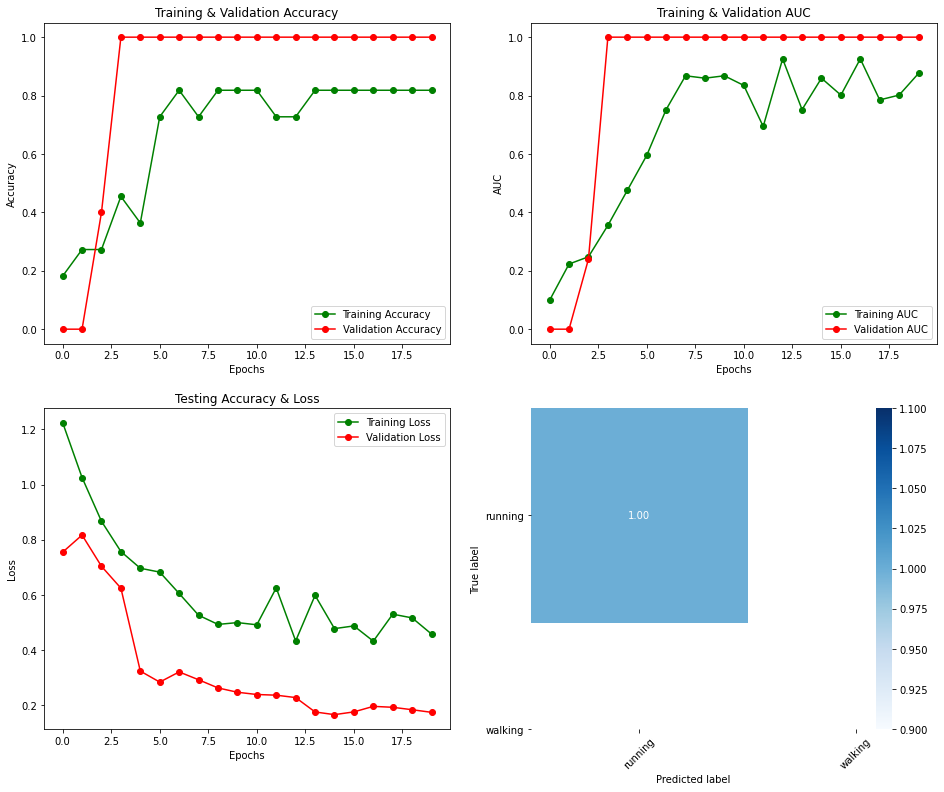

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Analysis after Model Training
dirname = 'plots'
epochs = 20
epochs = [i for i in range(epochs)]
train_acc = history.history['acc']
train_auc = history.history['auc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_auc = history.history['val_auc']
val_loss = history.history['val_loss']

idx = 0
plt.rcParams['figure.figsize'] = (16, 13)
plt.subplots_adjust(hspace=0.2)

plt.subplot(2, 2, 1)
# plt.clf()
plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.savefig(dirname + '/' + "Acc_plot.png",
#             facecolor='w', transparent=False)

# plt.show()

plt.subplot(2, 2, 2)
# plt.clf()

plt.plot(epochs, train_auc, 'go-', label='Training AUC')
plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
plt.title('Training & Validation AUC')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("AUC")
# plt.savefig(dirname + '/' + "AUC_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Testing Accuracy & Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.savefig(dirname + '/' + "Loss_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 4)
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# print(train_data.class_indices)
cm = confusion_matrix(y_true, y_pred)
# print(cm)
cm = cm / cm.astype(np.float).sum(axis=1)
# print(cm)
g = sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
g.set_xticklabels(g.get_xticklabels(), ha='center', rotation=45)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.ylabel("True label")
plt.xlabel("Predicted label")
figure = g.get_figure()
# figure.savefig(dirname + '/' + 'confusion_matrix.png',
#                 facecolor='w', transparent=False)
# plt.clf()


In [11]:
model.save("lstm_keras.h5")

In [12]:
from tensorflow.keras.models import load_model

model_loaded = load_model('lstm_keras.h5')

model_loaded.summary()

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 32)            3296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 32)             12416     
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6

In [13]:
model_loaded.predict(X_test)

array([[0.15893187, 0.8410681 ],
       [0.1606782 , 0.83932173],
       [0.16084747, 0.8391525 ],
       [0.16006066, 0.83993936],
       [0.16093728, 0.8390627 ]], dtype=float32)

In [14]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])